# POMDPs for Personalized Mammography Screening 

Alexander Goldberg, Lydia Goldberg, and Gabriela Merz 

## 1. Pre-generated Alpha Vectors

We have pre-generated all of the alpha vectors needed to solve the POMDP for you. If you would like to re-generate these alpha vectors (**warning: takes on the order of hours even with a commercial grade Linear Program Solver**), proceed to section 4. If you would like to use our pre-generated alpha vectors to play around with our results, continue in this section. 

Make sure you have run 

    pip install -r requirements.txt 
    
before attempting to use this notebook.

In [1]:
from monahan import MonahanSolve
from model import CancerPOMDP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore", message="elementwise comparison failed; returning scalar instead")
%matplotlib inline

/Users/gmerz/Desktop/Harvard/Years/Junior/Fall/CS182/FinalProject/pomdp/pomdp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We have pre-generated the alpha vectors for you for 20, 40, and 80 timesteps, corresponding to a patient living to ages 50, 60, and 80, respectively. Please choose the alpha vectors you would like to use in the cell below, which is defaulted to 80 timesteps.

In [2]:
NUM_VECTORS = 80

Here, we initialize the cancerPOMDP and read in the appropriate alpha vectors. 

In [3]:
cancerPOMDP = MonahanSolve(tmax = NUM_VECTORS)

In [4]:
cancerPOMDP.readAlpha('alpha/Simple/alpha' + str(NUM_VECTORS) + '.txt')

In [5]:
MAMMOGRAM_DICT = {0: 'WAIT', 1: 'GET A MAMMOGRAM'}

Now, we can experiment with different initial ages and different belief states! We can call "cancerPOMDP.chooseAction(beliefstate, time)" to see whether or not we should get a mammogram based on our initial probabilities.

In [6]:
# list of initial beliefs
# 0th index: probability you're healthy 
# first index: probability you have in-situ cancer 
# second index: probability you have invasive cancer 
# feel free to make these numbers up to test if our results are intuitive 
INITIAL_PROBS = [1, 0, 0]
AGE = 40

In [7]:
print MAMMOGRAM_DICT[cancerPOMDP.chooseAction(INITIAL_PROBS, (AGE - 40) * 2)]

WAIT


Good! So if your probability is 1 of being healthy, you opt to wait. Let's delve even futher into the data.

## 2. Examining the Data

We want to be able to see what kind of decisions we make under different conditions, 
i.e. different initial probabilities of cancers and health, and different ages. 
We create the function "genDF" to generate a dataframe of the decisions we make under
different probabilities, which we will then use to plot and visualize our results. Feel free to play around with how we generate the probabilities for the dataframe: right now, we look at discrete increments of .05, because it is easy to visualize on our heatmap below and doesn't take too long to generate. 

In [8]:
def genDF(pomdp, step = 0.05, high = 50): 
    '''
        function genDF
        
        params: pomdp MonohanSolve class 
        
        returns: a dataframe with columns 
        'Age': Age at which each decision was made, incremented by 5 years
            from 40 - max-age
        'Healthy Prior': Prior probability of health 
        'Insitu Prior' : Prior probability of in-situ cancer 
        'Inviasive Prior': Prior probability of invasive cancer
        'Decision' : 0 or 1, 0 to wait, 1 to get a Mammogram
    '''
    time, insitu, invasive, healthy, decisions = [], [], [], [], []
    for t in range(0, NUM_VECTORS + 1, 10): 
        for insitu_prob in range(high): 
            insitu_prob = step * insitu_prob
            for invasive_prob in range(high): 
                invasive_prob = step * invasive_prob
                if insitu_prob + invasive_prob > 1: 
                    continue 
                else: 
                    healthy_prob = 1 - insitu_prob - invasive_prob 
                    decision = pomdp.chooseAction([healthy_prob, insitu_prob, invasive_prob], t)
                    time.append((t * .5) + 40)
                    insitu.append(insitu_prob)
                    invasive.append(invasive_prob)
                    healthy.append(healthy_prob)
                    decisions.append(decision)
    return pd.DataFrame({'Age': time, 'Healthy Prior': healthy, 'In situ Prior': insitu, 'Invasive Prior': 
                             invasive, 'Decision': decisions})                    

Now, we generate a table of all the information!

In [9]:
df = genDF(cancerPOMDP)

You can feel free to play with the information like so: 

In [10]:
# look at the first five entries of the dataframe 
df.head()

,Age,Decision,Healthy Prior,In situ Prior,Invasive Prior
0,40.0,0,1.00,0.0,0.00
1,40.0,1,0.95,0.0,0.05
2,40.0,1,0.90,0.0,0.10
3,40.0,1,0.85,0.0,0.15
4,40.0,1,0.80,0.0,0.20


In [11]:
# look at every probability distribution where we opt to wait instead of
# recieving a mammogram
df[df['Decision'] == 0]

,Age,Decision,Healthy Prior,In situ Prior,Invasive Prior
0,40.0,0,1.00,0.00,0.00
231,45.0,0,1.00,0.00,0.00
462,50.0,0,1.00,0.00,0.00
693,55.0,0,1.00,0.00,0.00
924,60.0,0,1.00,0.00,0.00
1155,65.0,0,1.00,0.00,0.00
1386,70.0,0,1.00,0.00,0.00
1407,70.0,0,0.95,0.05,0.00
1617,75.0,0,1.00,0.00,0.00
1618,75.0,0,0.95,0.00,0.05


The dataframe is good and all, but you probably want to see some actual ~visualizations~. 
In that case, we define a function "plotAge" which takes in the dataframe we generated
and an age (from 40 - 75, incremented in 5's), and plots a heatmap. The x axis of the 
heatmap is your prior probability of in-situ cancer, and the y axis of your heatmap 
is your prior probability of invasive cancer. A square is <font color='red'>red</font> if you should opt to get
a <font color='red'>mammogram</font> for those probabilities, and a square is <font color='blue'>blue</font> if you should opt to <font color='blue'>wait</font>
instead of getting a mammogram. Note that we are not looking at probabilities in continuous space, but in discrete intervals of .005.

In [12]:
df = genDF(cancerPOMDP, step = 0.005, high = 35)

In [13]:
def plotAge(df, age): 
    '''
        function that plots a heatmap 
        of insitu prior vs. invasive prior
        blue squares indicate you opt to wait, 
        red square indicate you should recieve 
        a mammogram
    '''
    new_df = df[df['Age'] == age]
    new_df = new_df.pivot("Invasive Prior", "In situ Prior", "Decision")
    ax = sns.heatmap(new_df, cmap=ListedColormap(['blue', 'red']), alpha = .2, cbar = False,
                     yticklabels=2, xticklabels=4)
    ax.set_title('Mammogram Decisions for Age %s' % age)
    ax.invert_yaxis()

Let's plot the data for age 40!

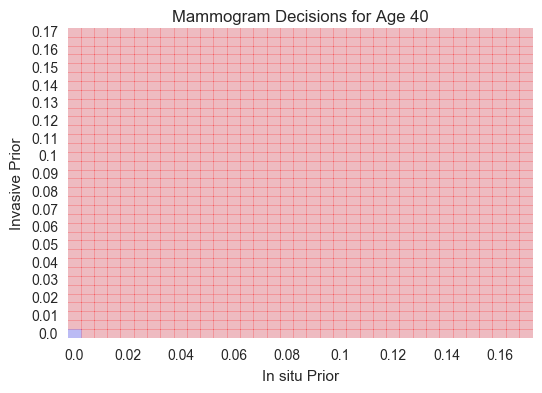

In [14]:
plotAge(df, 40)

So far, this is consistent with the results from the original paper. Let's see what happens when we up the age to 70: 

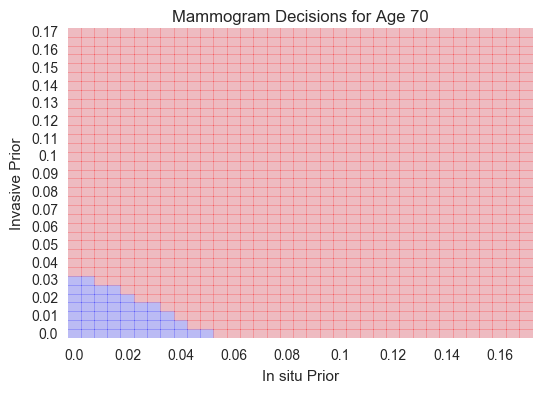

In [15]:
plotAge(df, 70)

And age 75...

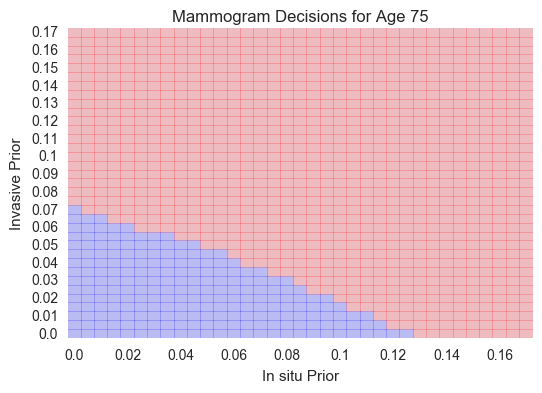

In [16]:
plotAge(df, 75)

Good! This is exactly the behavior we would expect. As we get older, the risk associated with not getting a mammogram becomes less important than the cost of getting a mammogram (which, as a refresher, is measured in Quality-Adjusted Life Years or QALYs). So, we become more likely to wait instead of opting to recieve a mammogram. 

#### Patient Examples ####

Let's explore some examples for two different patients! In the original paper by Ayer et. al, they explore examples of two patients: One with initial belief state [.997, .002, .001], and another with initial belief state [.987, .006, .007], aged 40 and 50 respectively. 

In the paper, the optimal policy for the first patient (aged 40) was to wait, and the optimal policy for the second patient (aged 50) was to get a mammogram. Although our underlying transition probabilities are slightly different from that o

In [17]:
PATIENT1 = [.997, .002, 0.001]
AGE = 40
decision = MAMMOGRAM_DICT[cancerPOMDP.chooseAction(PATIENT1, (AGE - 40) * 2)]
print decision

WAIT


Our model tells her to wait!

Now let's investigate the results for a different patient, aged 50. This patient has a 7/1000 chance of invasive cancer. Our model tells her to get a mammogram! 

In [18]:
PATIENT2 = [.987, .006, 0.007]
AGE = 50
decision = MAMMOGRAM_DICT[cancerPOMDP.chooseAction(PATIENT2, (AGE - 40) * 2)]
print decision

GET A MAMMOGRAM


## 3. How Observations Change the Belief State

Now that we have all this information, we want to verify that our belief state changes appropriately over time as a result of our actions. We'll first need to import some constants that make understanding our code a bit easier, and also write a function that prints our results nicely.

In [19]:
from modelConstants import W, M, MNEG, MPOS, SDNEG, SDPOS

In [20]:
def printBelief(b): 
    beliefs = ['being healthy', 'having in situ cancer', 'having invasive cancer']
    for prob, state in zip(b, beliefs): 
        print "Patient has probability %s of %s" % (prob, state)

We initialize a few belief states to test with: 

In [21]:
# patient is healthy with probability one 
HEALTHY = [1, 0, 0]
# patient is relatively likely to have in-situ cancer 
SPLIT = [.8, .2, 0]

As always, we first perform some sanity checks. If we believe our patient is healthy, and she recieves a negative mammogram, then she should continue to be healthy. Note that the first parameter in updateBeliefState is time, which we set to 0 to represent a woman at age 40.

In [22]:
printBelief(cancerPOMDP.updateBeliefState(0, HEALTHY, MNEG))

Patient has probability 0.996987951807 of being healthy
Patient has probability 0.00100401606426 of having in situ cancer
Patient has probability 0.00200803212851 of having invasive cancer


Now that that's out of the way, let's look at how a negative  self-detection vs. a negative mammogram changes the underlying belief state when a patient believes that they are probably healthy, but have a fairly high chance of in situ cancer (note that 0.2 is a fairly high probability in the context of having cancer. As we can see from our earlier heatmaps, with this probability of in situ cancer we would decide to get a mammogram). 

In [23]:
print "For split probability of healthy and in-situ with a negative mammogram: \n"
printBelief(cancerPOMDP.updateBeliefState(0, SPLIT, MNEG))

For split probability of healthy and in-situ with a negative mammogram: 

Patient has probability 0.828725843064 of being healthy
Patient has probability 0.0713250383488 of having in situ cancer
Patient has probability 0.0999491185875 of having invasive cancer


In [24]:
print "For split probability of healthy and in-situ with a negative self detection: \n"
printBelief(cancerPOMDP.updateBeliefState(0, SPLIT, SDNEG))

For split probability of healthy and in-situ with a negative self detection: 

Patient has probability 0.890513510352 of being healthy
Patient has probability 0.0455023979413 of having in situ cancer
Patient has probability 0.0639840917066 of having invasive cancer


Note that this is consistent with our original probabilities. We can also compare the changes in initial belief state if we were to have a positive self-detection:

In [25]:
print "Belief state of a patient after recieving self-detection:\n"
printBelief(cancerPOMDP.updateBeliefState(0, SPLIT, SDPOS))

Belief state of a patient after recieving self-detection:

Patient has probability 0.362541073384 of being healthy
Patient has probability 0.266155531216 of having in situ cancer
Patient has probability 0.3713033954 of having invasive cancer


The positive self-detection means that our patient is much more likely to have cancer than if there were a negative self-detection!

In [26]:
PATIENT = [0.9949, 0.0016, 0.0035]
AGE = 40

In [27]:
b = PATIENT
history = {}
for t in xrange(AGE - 40, cancerPOMDP.tmax):
    decision = MAMMOGRAM_DICT[cancerPOMDP.chooseAction(b, t)]
    if  decision == "WAIT":
        b = cancerPOMDP.updateBeliefState(t, b, SDNEG)
    else:
        b = cancerPOMDP.updateBeliefState(t, b, MNEG)
    history[(t/2 + 40) + 0.5*(t%2)] = {"b": b, "d": decision}

In [ ]:
history

{40.0: {'b': array([ 0.99312687,  0.00154353,  0.0053296 ]),
  'd': 'GET A MAMMOGRAM'},
 40.5: {'b': array([ 0.99182989,  0.0015233 ,  0.00664681]),
  'd': 'GET A MAMMOGRAM'},
 41.0: {'b': array([ 0.99087878,  0.00151565,  0.00760557]),
  'd': 'GET A MAMMOGRAM'},
 41.5: {'b': array([ 0.99018033,  0.00151247,  0.0083072 ]),
  'd': 'GET A MAMMOGRAM'},
 42.0: {'b': array([ 0.989667  ,  0.00151097,  0.00882203]),
  'd': 'GET A MAMMOGRAM'},
 42.5: {'b': array([ 0.98928954,  0.00151015,  0.0092003 ]),
  'd': 'GET A MAMMOGRAM'},
 43.0: {'b': array([ 0.9890119 ,  0.00150965,  0.00947845]),
  'd': 'GET A MAMMOGRAM'},
 43.5: {'b': array([ 0.98880764,  0.00150931,  0.00968305]),
  'd': 'GET A MAMMOGRAM'},
 44.0: {'b': array([ 0.98865734,  0.00150907,  0.00983359]),
  'd': 'GET A MAMMOGRAM'},
 44.5: {'b': array([ 0.98854674,  0.0015089 ,  0.00994436]),
  'd': 'GET A MAMMOGRAM'},
 45.0: {'b': array([ 0.98846535,  0.00150877,  0.01002588]),
  'd': 'GET A MAMMOGRAM'},
 45.5: {'b': array([ 0.98840544,

Overall, our results are intuitive and consistent! Feel free to experiment with different initial ages and belief states.

## 4. Re-solving the POMDP

If you would like to re-solve the POMDP, and have installed everything in requirements.txt, you should be able to run the following command to solve the POMDP (find the alpha vectors). In our write-up, we describe the various LP solvers we used to optimize. Since CPLEX is a commercial solver and cvxopt requires extra steps for installation, you will want to use pulp here (which is slower, but works). 


This command will generate the alpha vectors, and you will see a series of output including: 

1. Which LP solver you're using
2. The total number of alpha vectors at each timestep 
3. The total number of alpha vectors after Eagle's reduction 
4. The total number of alpha vectors after solving the Linear Program
5. Which time step you're on 
6. The amount of time it took for each step to run

If you would like to change the default number of timesteps, whether or not you write to a file, etc., please feel free to look through the code in model.py and monohan.py and modify settings as you prefer.

In [ ]:
newPOMDP = MonahanSolve(tmax = 20).solve()

Using LP Solver pulp 

Total alpha after enumeration: 2, time: 0.00
Total alpha after Eagle: 1, time: 0.00
Total alpha after LP: 1, time: 0.00
	LP construct time:  0
	LP solve time:  0
Completed time step  19 

Total alpha after enumeration: 2, time: 0.00
Total alpha after Eagle: 2, time: 0.00
Total alpha after LP: 2, time: 0.09
	LP construct time:  0.00261497497559
	LP solve time:  0.0836968421936
Completed time step  18 

Total alpha after enumeration: 6, time: 0.00
Total alpha after Eagle: 5, time: 0.00
Total alpha after LP: 4, time: 0.07
	LP construct time:  0.00864505767822
	LP solve time:  0.0619180202484
Completed time step  17 

Total alpha after enumeration: 20, time: 0.00
Total alpha after Eagle: 11, time: 0.00
Total alpha after LP: 8, time: 0.19
	LP construct time:  0.0432288646698
	LP solve time:  0.146596670151
Completed time step  16 

Total alpha after enumeration: 72, time: 0.00
Total alpha after Eagle: 32, time: 0.00
Total alpha after LP: 13, time: 0.74
	LP construct t